# Industry Sectoring

- igraph, community detection, modularity
- Text-based Network Industry Classification (Hoberg and Phillips, 2016)

Author: Terence Lim

In [2]:
import os
import zipfile
import io
import requests
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import igraph  # pip3 install cairocffi
from igraph import Graph
from itertools import chain
from finds.graph import igraph_info, igraph_community
from finds.database import SQL
from finds.busday import BusDay
from finds.structured import PSTAT
from finds.sectors import Sectoring
from settings import settings
    
sql = SQL(**settings['sql'])
bd = BusDay(sql)
pstat = PSTAT(sql, bd)
logdir = os.path.join(settings['images'], 'tnic')  # None
tnic_scheme = 'tnic2'

# Retrieve TNIC scheme from Hoberg and Phillips website
https://hobergphillips.tuck.dartmouth.edu/industryclass.htm

In [3]:
root = 'https://hobergphillips.tuck.dartmouth.edu/idata/'   
source = os.path.join(root, tnic_scheme + '_data.zip')
if source.startswith('http'):
    response = requests.get(source)
    source = io.BytesIO(response.content)
with zipfile.ZipFile(source).open(tnic_scheme + "_data.txt") as f:
    tnic_data = pd.read_csv(f, sep='\s+')
tnic_data.head()

,year,gvkey1,gvkey2,score
0,1989,1003,1076,0.0372
1,1989,1003,1518,0.0039
2,1989,1003,1594,0.0049
3,1989,1003,2184,0.0270
4,1989,1003,2213,0.0068


# Evaluate networks by year
1989, 1999, 2009, 2019

- ### Merge with CRSP and linked sic, naics codes
  - assign legacy industry codes (sic, naics) to stocks

- ### Lookup various sectoring labels
  - Fama-French codes5, 10, 12, 17, 30, 38, 48, 49
  - BEA industries

- ### Populate undirected unweighted graph
  - as igraph (note vertex names must be str type)

- ### Evaluate modularity of the various sectoring schemes
  - as a baseline to compare communities imposed by legacy schemes
  
- ### Apply community detection methods
  - try different methods to form new communities based on TNIC links
  
- ### Show sector representations in detected communities
  - to get some intuition of the new structure

Deleting vertex IDs with degree 0 [790, 1638]
     vertices   edges   density diameter simple directed global clustering  \
1989     4958  566488  0.046099        6   True    False          0.608358   

     local clustering weak components largest weak strong components  \
1989         0.462169               1         4958                 1   

     largest strong  
1989           4958  


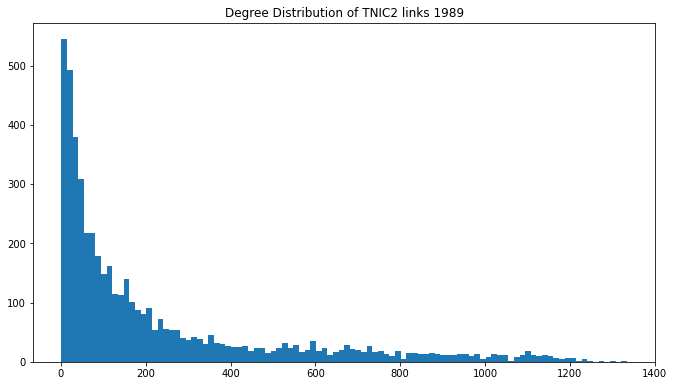

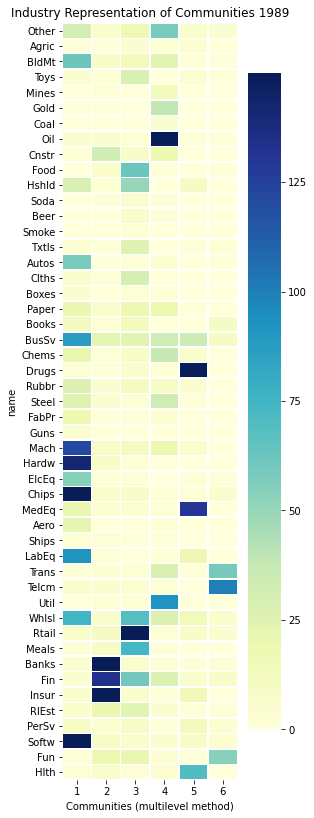

Deleting vertex IDs with degree 0 [72, 1839, 3484]
     vertices    edges   density diameter simple directed global clustering  \
1999     6822  1182246  0.050813        7   True    False          0.640347   

     local clustering weak components largest weak strong components  \
1999         0.517717               2         6820                 2   

     largest strong  
1999           6820  


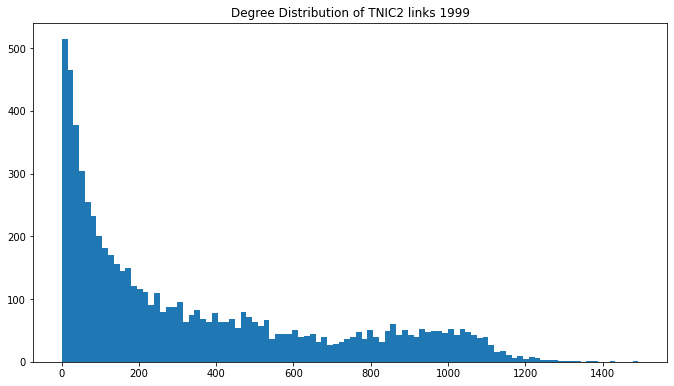

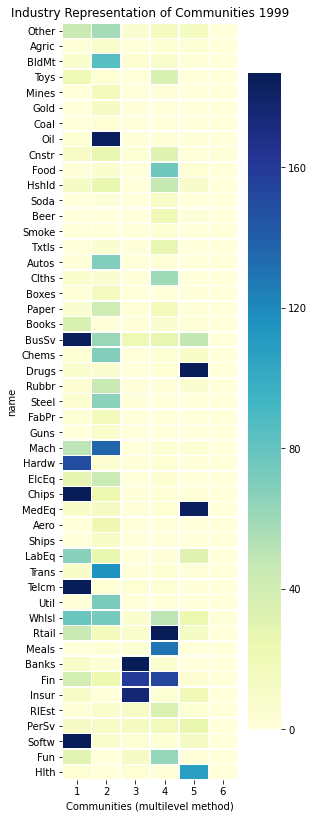

Deleting vertex IDs with degree 0 [3917]
     vertices   edges   density diameter simple directed global clustering  \
2009     4220  462526  0.051957        7   True    False          0.716458   

     local clustering weak components largest weak strong components  \
2009         0.545915               1         4220                 1   

     largest strong  
2009           4220  


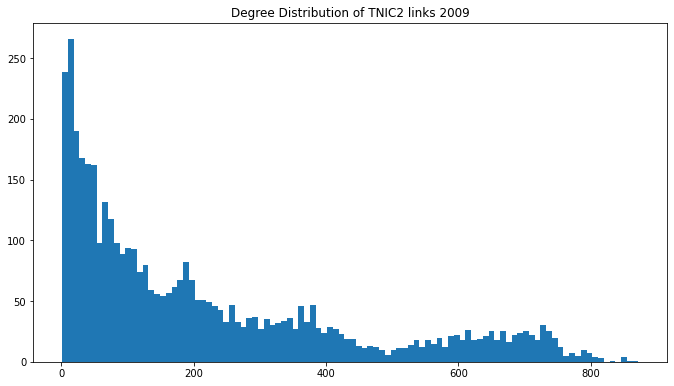

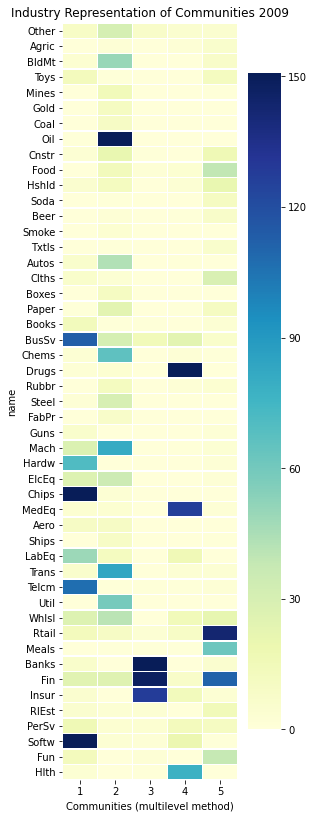

Deleting vertex IDs with degree 0 [3738]
     vertices   edges   density diameter simple directed global clustering  \
2019     3772  494039  0.069465        7   True    False          0.772073   

     local clustering weak components largest weak strong components  \
2019         0.579402               1         3772                 1   

     largest strong  
2019           3772  


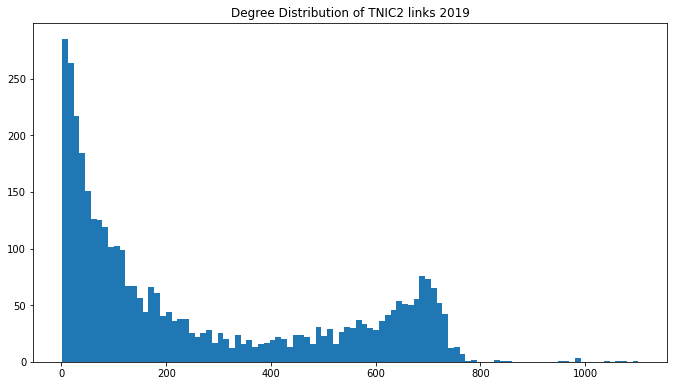

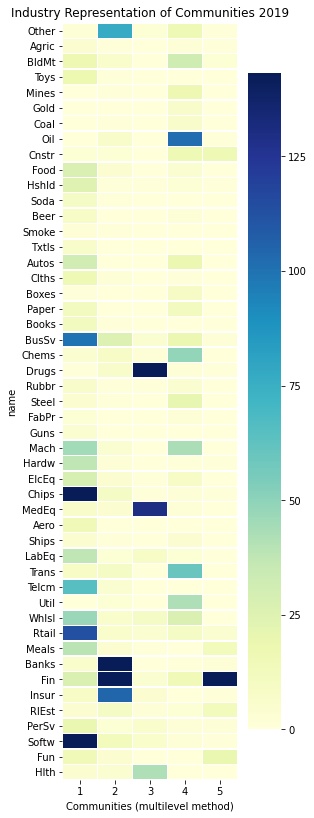

In [13]:
years = [1989, 1999, 2009, 2019]  # [1999, 2019]:
collect = {'modularity': {}, 'community': {}, 'info': {}}
for num, year in enumerate(years):
    
    # extract one year of tnic as data frame, merge in permno and sic codes
    tnic = tnic_data[tnic_data.year == year].dropna()
    vs = DataFrame(index=list(set(tnic['gvkey1']).union(set(tnic['gvkey2']))))
    for code in ['lpermno', 'sic', 'naics']:
        lookup = pstat.build_lookup('gvkey', code, fillna=0)
        vs[code] = lookup(vs.index)
    naics = Sectoring(sql, 'naics', fillna=0)   # supplement from crosswalk
    sic = Sectoring(sql, 'sic', fillna=0)
    vs['naics'] = vs['naics'].where(vs['naics'] > 0, naics[vs['sic']])
    vs['sic'] = vs['sic'].where(vs['sic'] > 0, naics[vs['naics']])
    Series(np.sum(vs > 0, axis=0)).rename('Non-missing').to_frame().T

    # apply sectoring schemes
    schemes = {'sic': ([f"codes{i}" for i in [5, 10, 12, 17, 30, 38, 48, 49]]
                       +['sic2', 'sic3']),
               'naics': ['bea1947', 'bea1963', 'bea1997']}
    codes = {}
    for key, sub in schemes.items():
        for scheme in sub:
            if scheme not in codes:
                codes[scheme] = Sectoring(sql, scheme,
                                          fillna=0 if scheme.startswith('sic')
                                          else '')
                vs[scheme] = codes[scheme][vs[key]]
            vs = vs[vs[scheme].ne(codes[scheme].fillna)]
    vs

    # create vertex (permno, naics, sic) and edge (score) attributes
    edges = tnic[tnic['gvkey1'].isin(vs.index) & tnic['gvkey2'].isin(vs.index)]
    attributes = edges['score'].values
    edges = edges[['gvkey1', 'gvkey2']].astype(str).values

    # populate igraph including attributes (note: vertex names must be str)
    g = Graph(directed=False)
    g.add_vertices(vs.index.astype(str).to_list(), vs.to_dict(orient='list'))
    g.add_edges(edges, {'score': attributes})
    degree = Series(g.vs.degree())   # to remove zero degree vertexes
    print('Deleting vertex IDs with degree 0', list(degree[degree==0].index))
    g.delete_vertices(degree[degree==0].index.to_list())
    g = g.simplify()         # remove self-loops and multi-edges
    s = Series(igraph_info(g)).rename(year)
    collect['info'][year] = s
    print(s.to_frame().T)

    # Plot degree distribution
    fig, ax = plt.subplots(clear=True, num=1, figsize=(10,6))
    Series(g.vs.degree()).hist(grid=False, ax=ax, bins=100)
    ax.set_title(f'Degree Distribution of {tnic_scheme.upper()} links {year}')
    plt.tight_layout(pad=3)
    plt.savefig(os.path.join(logdir, f'degree{year}.jpg'))
    plt.show()
    
    # evaluate modularity of sectoring schemes
    modularity = {}
    for scheme in sorted(chain(*schemes.values())):
        membership, uniques = pd.factorize(g.vs[scheme])
        modularity[scheme] = {'unique': len(uniques),
                              'modularity': g.modularity(membership)}
    f = DataFrame.from_dict(modularity, orient='index').sort_index()
    collect['modularity'][year] = f
    f

    # detect communities and report modularity
    clustering, dendogram = igraph_community(g)
    m = DataFrame.from_dict({key: {'modularity': c.modularity,
                                   'components': len(c.sizes())}
                             for key, c in clustering.items()}, orient='index')\
                 .sort_values('modularity', ascending=False)
    collect['community'][year] = m
    m
    
    # Plot industry representation at heatmap
    #.reindex(Sectoring.bea_industry.index)\
    detect = 'multilevel'
    c = clustering[detect]
    attr = 'codes49'
    indus = pd.concat([Series(c.subgraph(j).vs[attr]).value_counts().rename(i+1)
                       for i, j in enumerate(np.argsort(c.sizes())[::-1])],
                      axis=1).dropna(axis=0, how='all').fillna(0).astype(int)\
                      .reindex(codes[attr].sectors['name'].drop_duplicates(
                          keep='first'))
    fig, ax = plt.subplots(num=2+num, clear=True, figsize=(5,12))
    sns.heatmap(indus, square=False, linewidth=.5, ax=ax, yticklabels=1,
                cmap="YlGnBu", robust=True)
    if attr.startswith('bea'):
        ax.set_yticklabels(Sectoring.bea_industry[indus.index], size=10)
    else:
        ax.set_yticklabels(indus.index, size=10)
    ax.set_xlabel(f'Communities ({detect} method)')
    ax.set_title(f"Industry Representation of Communities {year}")
    fig.subplots_adjust(left=0.4)
    plt.tight_layout(pad=3)
    plt.savefig(os.path.join(logdir, f'{attr}_{year}.jpg'))
    plt.show()

# Compare modularity scores of communities imposed by legacy sectoring schemes, by year


In [14]:
collect['modularity'][1989]

,unique,modularity
bea1947,42,0.231922
bea1963,60,0.190153
bea1997,64,0.184785
codes10,10,0.282686
codes12,12,0.288480
codes17,17,0.257552
codes30,30,0.259417
codes38,37,0.233958
codes48,48,0.197826
codes49,49,0.196494


In [15]:
collect['modularity'][1999]

,unique,modularity
bea1947,42,0.348594
bea1963,60,0.278769
bea1997,64,0.275245
codes10,10,0.424942
codes12,12,0.437083
codes17,17,0.387711
codes30,30,0.392194
codes38,37,0.369490
codes48,48,0.312154
codes49,49,0.316763


In [16]:
collect['modularity'][2009]

,unique,modularity
bea1947,41,0.396640
bea1963,59,0.332237
bea1997,63,0.328591
codes10,10,0.463392
codes12,12,0.472103
codes17,17,0.407252
codes30,30,0.448120
codes38,36,0.401326
codes48,48,0.352102
codes49,49,0.350311


In [17]:
collect['modularity'][2019]

,unique,modularity
bea1947,41,0.371903
bea1963,59,0.308055
bea1997,63,0.306243
codes10,10,0.477552
codes12,12,0.461208
codes17,17,0.325447
codes30,30,0.448648
codes38,36,0.379518
codes48,48,0.333508
codes49,49,0.330849


# Compare modularity scores of new communities detected by various algorithms, by year.
- The multilevel algorithm in igraph module shows highest modularity scores for this data

In [18]:
collect['community'][1989]

,modularity,components
multilevel,0.424441,6
eigenvector,0.407874,5
infomap,0.395255,52
walktrap,0.390060,43
fastgreedy,0.308391,11
label_propogation,0.301091,4
components,0.000000,1


In [19]:
collect['community'][1999]

,modularity,components
multilevel,0.584560,6
infomap,0.571062,65
eigenvector,0.565932,6
walktrap,0.564744,32
label_propogation,0.563467,8
fastgreedy,0.513722,6
components,0.000002,2


In [20]:
collect['community'][2009]

,modularity,components
multilevel,0.606899,5
label_propogation,0.592128,5
eigenvector,0.590571,7
infomap,0.589959,46
walktrap,0.571401,42
fastgreedy,0.563423,4
components,0.000000,1


In [21]:
collect['community'][2019]

,modularity,components
multilevel,0.581296,5
eigenvector,0.576798,7
walktrap,0.574208,34
label_propogation,0.574201,6
infomap,0.566548,37
fastgreedy,0.544066,3
components,0.000000,1
